# BASIC STYLE TRANSFER

This notebook tries to explain the intrinsics of the most basic implementation of Style Transfer. Please, refer to the Readme.md file to see the general description of the project and the basic explanation.

## Imports

In [2]:
import numpy as np
import os
import sys
from keras import backend as K
from argparse import ArgumentParser
from google.colab import files

!pip install Pillow
from PIL import Image
from IPython.display import Image, display
import matplotlib.pyplot as plt

from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

from scipy.misc import imread, imresize, imsave, fromimage, toimage

from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import warnings

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

Using TensorFlow backend.


## Utils 

### String to boolean converter

In [0]:
#String to boolean converter
def str_to_bool(v):
    return v.lower() in ("true", "yes", "t", "1")

##Variables

In [0]:
img_width = 0
img_height = 0
img_WIDTH = 0
img_HEIGHT = 0
aspect_ratio = 0

THEANO_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
TH_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_th_dim_ordering_th_kernels_notop.h5'
TF_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


result_prefix = 'res_'

# Default value
rescale_image = str_to_bool("False")
#maintain_aspect_ratio = str_to_bool(args.maintain_aspect_ratio)

preserve_color = str_to_bool("False") # Default value
#these are the weights of the different loss components

#CONTENT WEIGHT
content_weight = 0.25 #default value
total_variation_weight = 8.5e-5 #default value
#total_variation_weight = args.tv_weight

#This array must be just of one position because we are not accepting more than
#one style images. It should be multiplied by the style_scale
style_weights = [1]

## Upload Images
To study how the network works, upload 2 images:

*   **Content image**: it is the base image. it provides the main content to the new output image.
*   **Style image**: it provides the artistic features of an image such as textures, pattern, brush strokes, color, curves and shapes.



In [5]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

print("Upload the Content Image")
imageContent = upload_files()[0]
print(imageContent)

print("Upload the Style Image")
imageStyle = upload_files()[0]

Upload the Content Image


Saving perro.jpg to perro.jpg
perro.jpg
Upload the Style Image


Saving vg.jpg to vg.jpg


... and display them:


Content Image


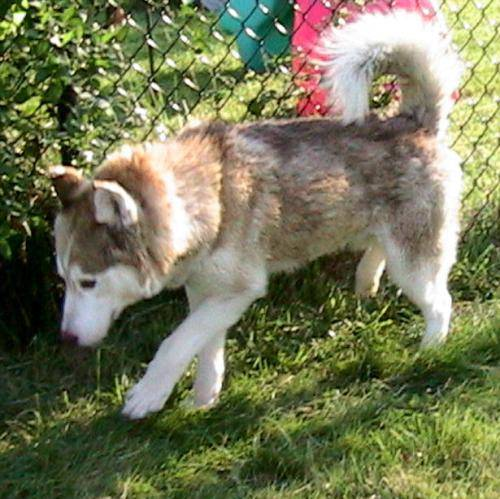


Style Image


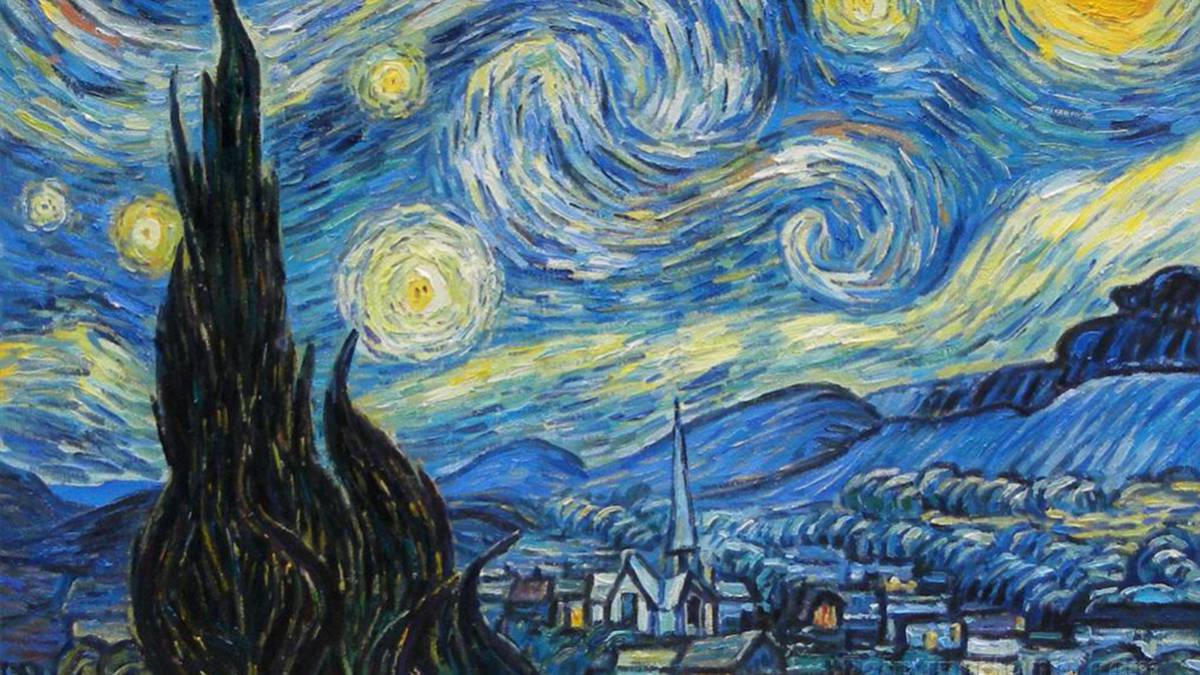

In [6]:
print()
print("Content Image")
display(Image(imageContent, width=500))
print()
print("Style Image")
display(Image(imageStyle, width=500))

## Image Preprocessing

Both images are preprocessed and the main parameters of the content image are saved to be used later since the style image will be resized to fit the content image and not otherwise.

In [7]:
global img_width, img_height, img_WIDTH, img_HEIGHT, aspect_ratio

imgContent = imread(imageContent, mode="RGB")  # Prevents crashes due to PNG images (ARGB)
imgStyle = imread(imageStyle, mode="RGB")  # Prevents crashes due to PNG images (ARGB)

#Saving Content image parameters
img_WIDTH = imgContent.shape[0]
img_HEIGHT = imgContent.shape[1]

print('Original sizes')
print(img_WIDTH)
print(img_HEIGHT)

aspect_ratio = float(img_HEIGHT) / img_WIDTH
img_width = 224    # Minimum image size: 400
img_height = int(img_width * aspect_ratio)

print('Modified sizes')
print(img_width)
print(img_height)

#Image resizing (style image resized to content image size)
imgContent = imresize(imgContent, (img_width, img_height)).astype('float32')
imgStyle = imresize(imgStyle, (img_width, img_height)).astype('float32')

# RGB -> BGR for content image
imgContent = imgContent[:, :, ::-1]
imgContent[:, :, 0] -= 103.939
imgContent[:, :, 1] -= 116.779
imgContent[:, :, 2] -= 123.68

# RGB -> BGR for style image
imgStyle = imgStyle[:, :, ::-1]
imgStyle[:, :, 0] -= 103.939
imgStyle[:, :, 1] -= 116.779
imgStyle[:, :, 2] -= 123.68

if K.image_dim_ordering() == "th":
    imgContent = imgContent.transpose((2, 0, 1)).astype('float32')
    imgStyle = imgStyle.transpose((2, 0, 1)).astype('float32')


imgContent = np.expand_dims(imgContent, axis=0)
imgStyle = np.expand_dims(imgStyle, axis=0)

Original sizes
499
500
Modified sizes
224
224


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


  ## Image to tensor
  
  Both images are converted to tensor to be used in further steps.



In [0]:
content_image = K.variable(imgContent)
style_image = K.variable(imgStyle)

# this will contain our generated image
if K.image_dim_ordering() == 'th':
    combination_image = K.placeholder((1, 3, img_width, img_height))
else:
    combination_image = K.placeholder((1, img_width, img_height, 3))

image_tensors = [content_image]
image_tensors.append(style_image)
image_tensors.append(combination_image)

nb_tensors = len(image_tensors)
nb_style_images = nb_tensors - 2 # Content and Output image not considered

# combine the various images into a single Keras tensor
input_tensor = K.concatenate(image_tensors, axis=0)

if K.image_dim_ordering() == "th":
    shape = (nb_tensors, 3, img_width, img_height)
else:
    shape = (nb_tensors, img_width, img_height, 3)

ip = Input(tensor=input_tensor, batch_shape=shape)


## Network Structure

### VGG16

We will be using an already trained Convolutional Network (also known as ConvNet). ConvNet apply the basic principle of convolution, the input image is convolved with several filters and feature maps are generated. These feature maps are then convolved with some more filters and some more feature maps are generated.

CNN leverage local connectivity, parameter sharing and pooling/subsampling hidden units.

We will use VGG (Visual Geometry Group from Univ. Oxford). 
Next figure is a visualization of the VGG architecture: 

![](https://1.bp.blogspot.com/-bHgaNqUKkR0/WarxZecuxbI/AAAAAAAATyk/7ABN8gZ-H7gdJ6sgU8rNYpR06LwMjWVTwCLcBGAs/s1600/The%2BVGG%2BNet%2BArchitecture%2B-%2BVGG16%2B-%2BHorizontal.png) 

This network uses only 3×3 convolutional layers stacked on top of each other in increasing depth. Max pooling layers are used to reduce volume size. Finally, two fully-connected layers, each with 4,096 nodes, are then followed by a softmax classifier. 

We will use Vgg16. The “16” stand for the number of weight layers in the network. VGG16 has the structure of the figure above.

The main drawbacks of VGG are its slowness to train and the network architecture weights themselves, which are quite large in terms of disk/bandwidth.

### The code
In this section, network model is defined.
As it can be seen, the activation function used is ReLu (Rectified Linear Unit), which is defined as the positive part of its argument.
We chose the max pooling layer since it offers sharper images, although the documentation says the average pooling layer gives smoother contours.

In [0]:
# VGG19 network with our 3 images as input
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding='same')(ip)
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding='same')(x)
# Average Pooling can also be used with: x = AveragePooling2D((2, 2), strides=(2, 2))(x) in all layers
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)

x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding='same')(x)
x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)

x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding='same')(x)
#x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)

x = Convolution2D(512, (3, 3), activation='relu', name='conv4_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_3', padding='same')(x)
#x = Convolution2D(512, (3, 3), activation='relu', name='conv4_4', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)

x = Convolution2D(512, (3, 3), activation='relu', name='conv5_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_3', padding='same')(x)
#x = Convolution2D(512, (3, 3), activation='relu', name='conv5_4', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
#x = AveragePooling2D((2, 2), strides=(2, 2))(x)

model = Model(ip, x)

### Download the pretrained model

Since pretraining a model could take hours, we just download the pretrained model weights in order to speed up the process.

In [10]:
if K.image_dim_ordering() == "th":
  #weights = get_file('vgg19_weights_th_dim_ordering_th_kernels_notop.h5', TH_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
  weights = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5', THEANO_WEIGHTS_PATH_NO_TOP, cache_subdir='models')

else:
  #weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
  weights = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_WEIGHTS_PATH_NO_TOP, cache_subdir='models')

model.load_weights(weights)

if K.backend() == 'tensorflow' and K.image_dim_ordering() == "th":
    warnings.warn('You are using the TensorFlow backend, yet you '
                  'are using the Theano '
                  'image dimension ordering convention '
                  '(`image_dim_ordering="th"`). '
                  'For best performance, set '
                  '`image_dim_ordering="tf"` in '
                  'your Keras config '
                  'at ~/.keras/keras.json.')
    convert_all_kernels_in_model(model)

print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
shape_dict = dict([(layer.name, layer.output_shape) for layer in model.layers])
print(shape_dict)

58892288/58889256 [==============================] - 1s 0us/step
Model loaded.
{'input_1': (3, 224, 224, 3), 'conv1_1': (3, 224, 224, 64), 'conv1_2': (3, 224, 224, 64), 'max_pooling2d_1': (3, 112, 112, 64), 'conv2_1': (3, 112, 112, 128), 'conv2_2': (3, 112, 112, 128), 'max_pooling2d_2': (3, 56, 56, 128), 'conv3_1': (3, 56, 56, 256), 'conv3_2': (3, 56, 56, 256), 'conv3_3': (3, 56, 56, 256), 'max_pooling2d_3': (3, 28, 28, 256), 'conv4_1': (3, 28, 28, 512), 'conv4_2': (3, 28, 28, 512), 'conv4_3': (3, 28, 28, 512), 'max_pooling2d_4': (3, 14, 14, 512), 'conv5_1': (3, 14, 14, 512), 'conv5_2': (3, 14, 14, 512), 'conv5_3': (3, 14, 14, 512), 'max_pooling2d_5': (3, 7, 7, 512)}


## Loss

Total loss computation:

![](https://cdn-images-1.medium.com/max/2000/1*F3yL2YQCQ3BH3cGWBRF9Hw.png =350x)

### Content Loss

It is defined as the mean squared error of difference between feature map representation (values of hidden activations) of the content image (P_l) and feature map representation of the generated image (F_l) at hidden layer (l)

![](https://cdn-images-1.medium.com/max/1600/1*Wd0L4_LA77g5cLWon7L3Hw.png =350x)

In [0]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    channel_dim = 0 if K.image_dim_ordering() == "th" else -1

    try:
        channels = K.int_shape(base)[channel_dim]
    except TypeError:
        channels = K.shape(base)[channel_dim]
    size = img_width * img_height
    
    #By default the type of content loss is 0: 
    multiplier = 1.
    #... but it can be one of the following:
    # type 2 -> multiplier = 1. / (channels * size)
    # type 1 -> 
    #multiplier = 1. / (2. * (channels ** 0.5) * (size ** 0.5))

    return multiplier * K.sum(K.square(combination - base))

### Style Loss

It is defined as mean squared error between the Gram Matrix representations for the style image (A_l) and the generated image (G_l) respectively in layer (l). Since we have defined our style through the combination of multiple layers, we would sum up the square of the difference for each layer (l). Please note that N and M stands for the size of the height and width of the style image

![](https://cdn-images-1.medium.com/max/1600/1*3LnRslYfEIqdLmVDP3PP3w.png =350x)

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination, mask_path=None, nb_channels=None):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_width * img_height
    return K.sum(K.square(C - S)) / (4. * (channels ** 2) * (size ** 2))


### Gram Matrix

It is only used in style loss computation.

In [0]:
#Gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == "th":
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

### Loss computation



In [14]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict["conv4_2"]  # 'conv5_2' or 'conv4_2'     # Content layers
print(layer_features)
base_image_features = layer_features[0, :, :, :] #Extracts values from the content image (0)
combination_features = layer_features[nb_tensors - 1, :, :, :] #Extracts values from the combination image (nb_tensors-1=2)

print("Computing content loss w/ weight =", content_weight)
loss = loss + content_weight * content_loss(base_image_features,combination_features)
print("-------------------------------------")
print()


channel_index = 1 if K.image_dim_ordering() == "th" else -1

feature_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'] #Style Layers
for layer_name in feature_layers:
    print("Extracting features from layer", layer_name)
    layer_features = outputs_dict[layer_name]
    shape = shape_dict[layer_name]
    combination_features = layer_features[nb_tensors - 1, :, :, :]
    style_reference_features = layer_features[1:nb_tensors - 1, :, :, :]
    sl = []
    
    for j in range(nb_style_images):
        print("  -   Style_reference_features:",style_reference_features[j])
        sl.append(style_loss(style_reference_features[j], combination_features, None, shape))        

    for j in range(nb_style_images):
        print("  -   Computing style loss w/ weight =", style_weights[j])
        loss = loss + (style_weights[j] / len(feature_layers)) * sl[j]
        print("  -   SL(j) - ", sl[j])
        print()

if K.image_dim_ordering() == 'th':
    a = K.square(combination_image[:, :, :img_width - 1, :img_height - 1] - combination_image[:, :, 1:, :img_height - 1])
    b = K.square(combination_image[:, :, :img_width - 1, :img_height - 1] - combination_image[:, :, :img_width - 1, 1:])
else:
    a = K.square(combination_image[:, :img_width - 1, :img_height - 1, :] - combination_image[:, 1:, :img_height - 1, :])
    b = K.square(combination_image[:, :img_width - 1, :img_height - 1, :] - combination_image[:, :img_width - 1, 1:, :])
t_variation = K.sum(K.pow(a + b, 1.25))

loss = loss + total_variation_weight * t_variation

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


Tensor("conv4_2/Relu:0", shape=(3, 28, 28, 512), dtype=float32)
Computing content loss w/ weight = 0.25
-------------------------------------

Extracting features from layer conv1_1
  -   Style_reference_features: Tensor("strided_slice_4:0", shape=(224, 224, 64), dtype=float32)
  -   Computing style loss w/ weight = 1
  -   SL(j) -  Tensor("truediv:0", shape=(), dtype=float32)

Extracting features from layer conv2_1
  -   Style_reference_features: Tensor("strided_slice_10:0", shape=(112, 112, 128), dtype=float32)
  -   Computing style loss w/ weight = 1
  -   SL(j) -  Tensor("truediv_1:0", shape=(), dtype=float32)

Extracting features from layer conv3_1
  -   Style_reference_features: Tensor("strided_slice_16:0", shape=(56, 56, 256), dtype=float32)
  -   Computing style loss w/ weight = 1
  -   SL(j) -  Tensor("truediv_2:0", shape=(), dtype=float32)

Extracting features from layer conv4_1
  -   Style_reference_features: Tensor("strided_slice_22:0", shape=(28, 28, 512), dtype=float32)
 

##Evaluation
### Evaluate loss and grad

In [0]:
def eval_loss_and_grads(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, img_width, img_height))
    else:
        x = x.reshape((1, img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

### Evaluation 
The Evaluator class makes possible to compute loss and gradients in one pass, while retrieving them via two separate functions, "loss" and "grads". This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
evaluator = Evaluator()


Starting iteration 1 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 1822589300.0  Improvement : 0.000 %
Image saved as res_at_iteration_1.png
Iteration 1 completed in 7s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


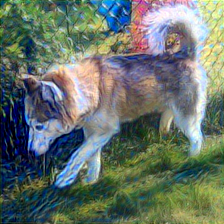


Starting iteration 2 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 1212586000.0  Improvement : 33.469 %
Image saved as res_at_iteration_2.png
Iteration 2 completed in 3s


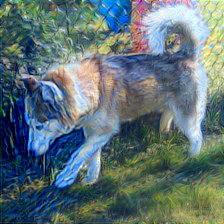


Starting iteration 3 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 1083486300.0  Improvement : 10.647 %
Image saved as res_at_iteration_3.png
Iteration 3 completed in 3s


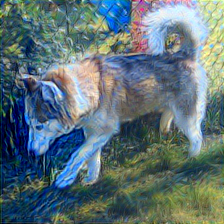


Starting iteration 4 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 1022423040.0  Improvement : 5.636 %
Image saved as res_at_iteration_4.png
Iteration 4 completed in 3s


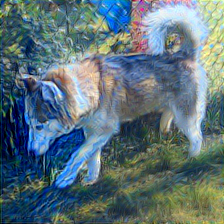


Starting iteration 5 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 990165500.0  Improvement : 3.155 %
Image saved as res_at_iteration_5.png
Iteration 5 completed in 3s


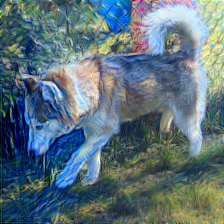


Starting iteration 6 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 970568640.0  Improvement : 1.979 %
Image saved as res_at_iteration_6.png
Iteration 6 completed in 3s


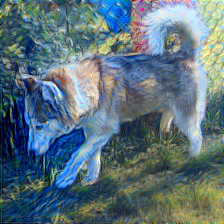


Starting iteration 7 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 955823800.0  Improvement : 1.519 %
Image saved as res_at_iteration_7.png
Iteration 7 completed in 3s


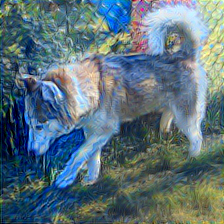


Starting iteration 8 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 944817800.0  Improvement : 1.151 %
Image saved as res_at_iteration_8.png
Iteration 8 completed in 3s


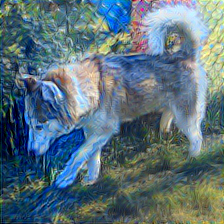


Starting iteration 9 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 936679200.0  Improvement : 0.861 %
Image saved as res_at_iteration_9.png
Iteration 9 completed in 3s


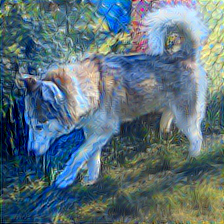


Starting iteration 10 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 930580100.0  Improvement : 0.651 %
Image saved as res_at_iteration_10.png
Iteration 10 completed in 3s


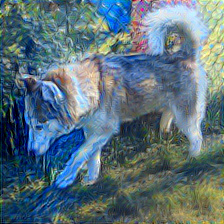


Starting iteration 11 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 926167300.0  Improvement : 0.474 %
Image saved as res_at_iteration_11.png
Iteration 11 completed in 3s

Starting iteration 12 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 922510500.0  Improvement : 0.395 %
Image saved as res_at_iteration_12.png
Iteration 12 completed in 3s

Starting iteration 13 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 919590500.0  Improvement : 0.317 %
Image saved as res_at_iteration_13.png
Iteration 13 completed in 3s

Starting iteration 14 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 917265400.0  Improvement : 0.253 %
Image saved as res_at_iteration_14.png
Iteration 14 completed in 3s

Starting iterat

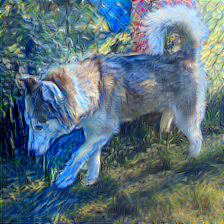


Starting iteration 21 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 908326700.0  Improvement : 0.078 %
Image saved as res_at_iteration_21.png
Iteration 21 completed in 3s

Starting iteration 22 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 907717570.0  Improvement : 0.067 %
Image saved as res_at_iteration_22.png
Iteration 22 completed in 3s

Starting iteration 23 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 907153600.0  Improvement : 0.062 %
Image saved as res_at_iteration_23.png
Iteration 23 completed in 3s

Starting iteration 24 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 906675000.0  Improvement : 0.053 %
Image saved as res_at_iteration_24.png
Iteration 24 completed in 3s

Starting iterat

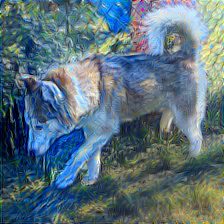


Starting iteration 31 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 904424060.0  Improvement : 0.025 %
Image saved as res_at_iteration_31.png
Iteration 31 completed in 3s

Starting iteration 32 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 904214400.0  Improvement : 0.023 %
Image saved as res_at_iteration_32.png
Iteration 32 completed in 3s

Starting iteration 33 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 904029300.0  Improvement : 0.020 %
Image saved as res_at_iteration_33.png
Iteration 33 completed in 3s

Starting iteration 34 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 903858050.0  Improvement : 0.019 %
Image saved as res_at_iteration_34.png
Iteration 34 completed in 3s

Starting iterat

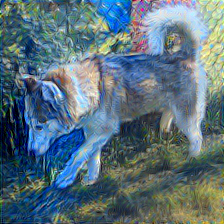


Starting iteration 41 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 902769200.0  Improvement : 0.015 %
Image saved as res_at_iteration_41.png
Iteration 41 completed in 3s

Starting iteration 42 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 902628500.0  Improvement : 0.016 %
Image saved as res_at_iteration_42.png
Iteration 42 completed in 3s

Starting iteration 43 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 902492350.0  Improvement : 0.015 %
Image saved as res_at_iteration_43.png
Iteration 43 completed in 3s

Starting iteration 44 of 50
Evaluator loss <bound method Evaluator.loss of <__main__.Evaluator object at 0x7ff02015fb38>>
Current loss value: 902362940.0  Improvement : 0.014 %
Image saved as res_at_iteration_44.png
Iteration 44 completed in 3s

Starting iterat

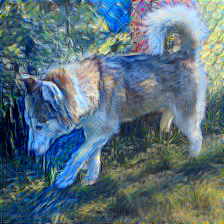

In [17]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

# By default, init_image = "content". If it was gray, it would be the same.
x = imgContent

# If init_image = "noise":
#x = np.random.uniform(0, 255, (1, img_width, img_height, 3)) - 128.
#if K.image_dim_ordering() == "th":
#  x = x.transpose((0, 3, 1, 2))

# Default color = false
color_mask = None

# Default value num_iter 10
num_iter = 50
prev_min_val = -1

# Default value min_improvement = 0.0. Defines minimum improvement required to continue the script
improvement_threshold = float(0.0)

for i in range(num_iter):
    print()
    print("Starting iteration %d of %d" % ((i + 1), num_iter))
    start_time = time.time()
    

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print("Evaluator loss",evaluator.loss)
    if prev_min_val == -1:
        prev_min_val = min_val

    improvement = (prev_min_val - min_val) / prev_min_val * 100

    print('Current loss value:', min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
    
    #----------------------
    # Deprocess image
    # save current generated image
    x_copy = x.copy()    
    if K.image_dim_ordering() == "th":
        x_copy = x_copy.reshape((3, img_width, img_height))
        x_copy = x_copy.transpose((1, 2, 0))
    else:
        x_copy = x_copy.reshape((img_width, img_height, 3))

    x_copy[:, :, 0] += 103.939
    x_copy[:, :, 1] += 116.779
    x_copy[:, :, 2] += 123.68

    # BGR -> RGB
    x_copy = x_copy[:, :, ::-1]

    img = np.clip(x_copy, 0, 255).astype('uint8')
    #----------------------

    #if preserve_color and content is not None:
        #img = original_color_transform(content, img, mask=color_mask)

    if not rescale_image:
        img_ht = int(img_width * aspect_ratio)
        #print("Rescaling Image to (%d, %d)" % (img_width, img_ht))
        img = imresize(img, (img_width, img_ht), interp="bilinear") #Default value

    if rescale_image:
        #print("Rescaling Image to (%d, %d)" % (img_WIDTH, img_HEIGHT))
        img = imresize(img, (img_WIDTH, img_HEIGHT), interp="bilinear") #Default value

    fname = result_prefix + 'at_iteration_%d.png' % (i + 1)
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i + 1, end_time - start_time))
    if ((i+1)%10 == 0) or (i+1) in range(0, 10):
      display(Image(fname, width=500))

    if improvement_threshold is not 0.0:
        if improvement < improvement_threshold and improvement is not 0.0:
            print("Improvement (%f) is less than improvement threshold (%f). Early stopping script." % (
                improvement, improvement_threshold))
            exit()